In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import operator
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
import theano.tensor as tt
import warnings

from scipy.special import expit
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [2]:
warnings.filterwarnings("ignore")

## Question 1

For the example in the Covariance functions and kernels section make sure you understand the relationship between the input data and the generated covariance matrix. Try using other input such as `data = np.random.normal(size=4)`.

<p>
    <font color="blue">
        <p>Covariance matrix reflects the exponent of the squared distance between pairs of points.</p>
    </font>
</p>

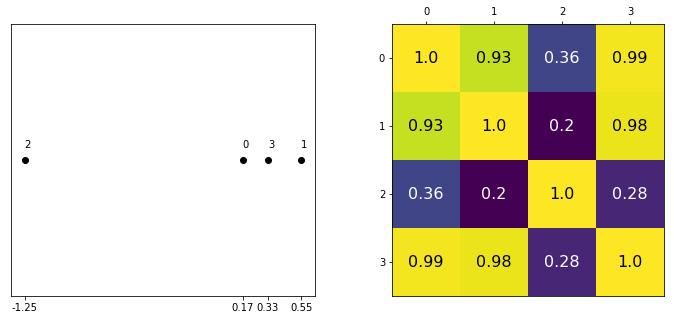

In [3]:
def exp_quad_kernel(x, knots, ℓ=1):
    """exponentiated quadratic kernel"""
    return np.array([np.exp(-(x-k)**2 / (2*ℓ**2)) for k in knots])


data = np.random.normal(size=4)
cov = exp_quad_kernel(data, data, 1)

_, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = np.ravel(ax)
ax[0].plot(data, np.zeros_like(data), 'ko')
ax[0].set_yticks([])

for idx, i in enumerate(data):
    ax[0].text(i, 0+0.005, idx)
ax[0].set_xticks(data)
ax[0].set_xticklabels(np.round(data, 2))

ax[1].grid(False)
im = ax[1].imshow(cov)
colors = ['w', 'k']
for i in range(len(cov)):
    for j in range(len(cov)):
        ax[1].text(j, i, round(cov[i, j], 2),
            color=colors[int(im.norm(cov[i, j]) > 0.5)],
            ha='center', va='center', fontdict={'size': 16})

ax[1].set_xticks(range(len(data)))
ax[1].set_yticks(range(len(data)))
ax[1].xaxis.tick_top()

## Question 2

Rerun the code generating Figure 7.3 and increase the number of samples obtained from the GP-prior to around 200. In the original figure the number of samples is 2. Which is the range of the generated `y` values?

<p>
    <font color="blue">
        <p>Range of y-values with 200 samples: [-3 to +3]</p>
    </font>
</p>

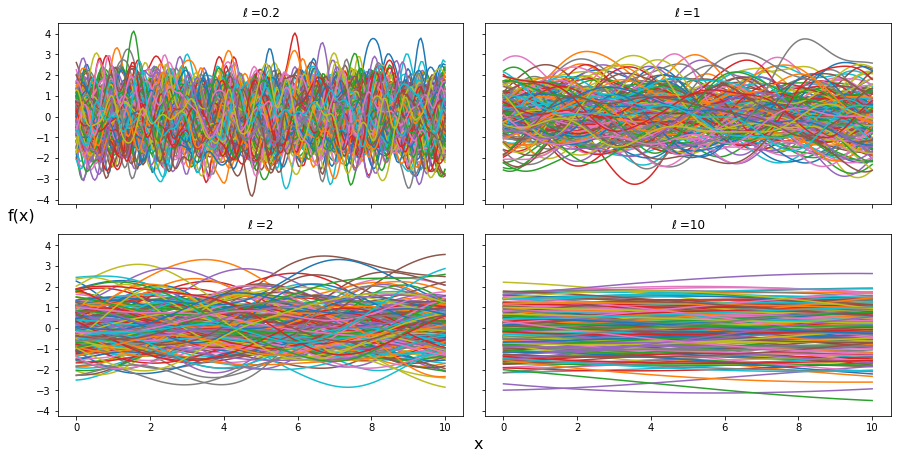

In [4]:
np.random.seed(24)
test_points = np.linspace(0, 10, 200)
fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey=True, constrained_layout=True)
ax = np.ravel(ax)

for idx, ℓ in enumerate((0.2, 1, 2, 10)):
    cov = exp_quad_kernel(test_points, test_points, ℓ)
    ax[idx].plot(test_points, stats.multivariate_normal.rvs(cov=cov, size=200).T)
    ax[idx].set_title(f'ℓ ={ℓ}')
    
fig.text(0.51, -0.03, 'x', fontsize=16)
fig.text(-0.03, 0.5, 'f(x)', fontsize=16)
_ = plt.show()

## Question 3

For the generated plot in the previous exercise. Compute the standard deviation for the values of `y` at each point. Do this in the following form:

* Visually, just observing the plots
* Directly from the values generated from stats.multivariate_normal.rvs
* By inspecting the covariance matrix (if you have doubts go back to exercise 1)

Did the values you get from these 3 methods agree?

<p>
    <font color="blue">
        <ul>
            <li>Range of f(x) looks like it is [-3, +3], which is about 3*&sigma;, so &sigma; is 3/3 or about 1</li>
            <li>Computed SD from the multivariate normal distribution is around 0.99</li>
            <li>From Covariance matrix, diagonal is the variance, so SD is mean of square root, is 1</li>
        </ul>
    </font>
</p>

In [5]:
for idx, ℓ in enumerate((0.2, 1, 2, 10)):
    print("ℓ:", ℓ)
    cov = exp_quad_kernel(test_points, test_points, ℓ)
    values = stats.multivariate_normal.rvs(cov=cov, size=200)
    print("sd (from cov):", np.mean(np.sqrt(np.diag(cov))), "(from dist):", np.std(values))

ℓ: 0.2
sd (from cov): 1.0 (from dist): 1.0048951275119626
ℓ: 1
sd (from cov): 1.0 (from dist): 1.0016074991781574
ℓ: 2
sd (from cov): 1.0 (from dist): 0.9930809408334933
ℓ: 10
sd (from cov): 1.0 (from dist): 1.1377836913261763


## Question 4

Re-run the model `model_reg` and get new plots but using as `test_points` `X_new` `np.linspace(np.floor(x.min()), 20,
100)[:,None]`. What did you observed? How is this related to the specification of the GP-prior?

<p>
    <font color="blue">
        <p>We fit our model for range of [0, 10] for our x-values. Our original prediction range was also from [0, 10] as described in the chapter. However, in this exercise we change the range to [0, 20]. We observe that the predictions of the model from x=[0, 10] are quite good, but predictions starting from [10, 20] are very erratic.</p>
        <p>The uncertainty in the predictions may be related to the fact that we specified a prior only over the range [0, 10] so the model does not attempt to constrain the predictions outside this range.</p>
    </font>
</p>

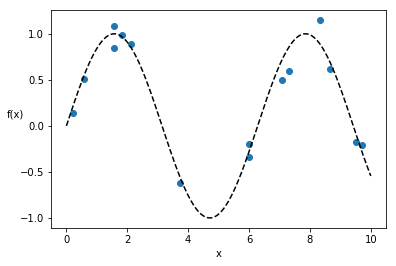

In [6]:
np.random.seed(42)

x = np.random.uniform(0, 10, size=15)
y = np.random.normal(np.sin(x), 0.1)

plt.plot(x, y, 'o')
true_x = np.linspace(0, 10, 200)
plt.plot(true_x, np.sin(true_x), 'k--')
plt.xlabel('x')
plt.ylabel('f(x)', rotation=0)
_ = plt.show()

In [7]:
X = x[:, None]
with pm.Model() as model_reg_q4:
    # hyperprior for length scale kernel parameter
    ℓ = pm.Gamma('ℓ', 2, 0.5)
    # instantiate a covariance function
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    # instantiate a GP prior
    gp = pm.gp.Marginal(cov_func=cov)
    # prior
    ϵ = pm.HalfNormal('ϵ', 25)
    # likelihood
    y_pred = gp.marginal_likelihood('y_pred', X=X, y=y, noise=ϵ)
    trace_reg_q4 = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, ℓ]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:36<00:00, 600.47draws/s]
The acceptance probability does not match the target. It is 0.8857901482325573, but should be close to 0.8. Try to increase the number of tuning steps.


In [8]:
X_new = np.linspace(np.floor(x.min()), 20, 100)[:,None]
with model_reg_q4:
    n_pred = gp.conditional('n_pred', X_new)
    pred_samples = pm.sample_posterior_predictive(trace_reg_q4, vars=[n_pred], samples=100)

100%|██████████| 100/100 [00:01<00:00, 52.72it/s]


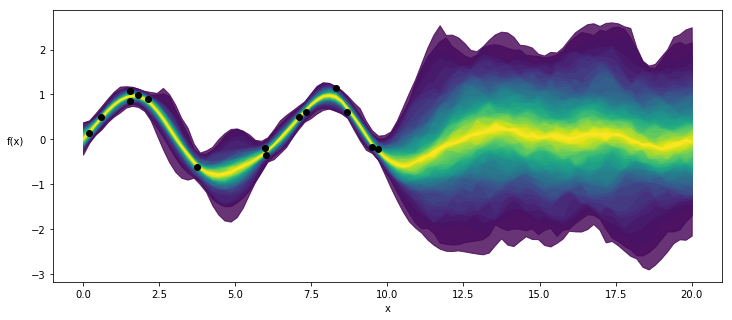

In [9]:
_, ax = plt.subplots(figsize=(12,5))

pm.gp.util.plot_gp_dist(ax, pred_samples['n_pred'], X_new, palette='viridis', plot_samples=False)

ax.plot(X, y, 'ko')
ax.set_xlabel('x')
ax.set_ylabel('f(x)', rotation=0, labelpad=15)
_ = plt.show()

## Question 5

Go back to exercise 1, but this time use a linear kernel (see the accompanying code for a linear kernel)

<p>
    <font color="blue">
        <p>Covariance matrix shows inverse of distances between points, i.e., closer the points, higher their similarity. Also diagonal is no longer all 1 but varies by point.</p>
    </font>
</p>

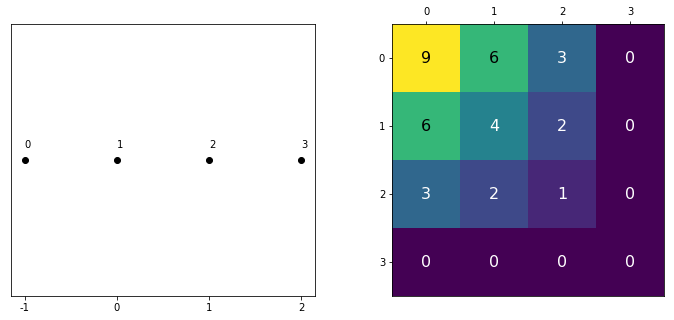

In [10]:
def linear_kernel(x, knots):
    """ linear kernel """
    return np.array([(x - 2) * (k - 2) for k in knots])

# data = np.random.normal(size=4)
data = np.array([-1, 0, 1, 2])
cov = linear_kernel(data, data)

_, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = np.ravel(ax)
ax[0].plot(data, np.zeros_like(data), 'ko')
ax[0].set_yticks([])

for idx, i in enumerate(data):
    ax[0].text(i, 0+0.005, idx)
ax[0].set_xticks(data)
ax[0].set_xticklabels(np.round(data, 2))

ax[1].grid(False)
im = ax[1].imshow(cov)
colors = ['w', 'k']
for i in range(len(cov)):
    for j in range(len(cov)):
        ax[1].text(j, i, round(cov[i, j], 2),
            color=colors[int(im.norm(cov[i, j]) > 0.5)],
            ha='center', va='center', fontdict={'size': 16})

ax[1].set_xticks(range(len(data)))
ax[1].set_yticks(range(len(data)))
ax[1].xaxis.tick_top()

## Question 6

Go and check the section https://docs.pymc.io/notebooks/GP-MeansAndCovs.html from PyMC3 documentation.

## Question 7

Run a logistic regression model for the `space_flu` data. What do you see? Can you explain the result?

<p>
    <font color="blue">
        <p>A simple logistic regression model is actually quite a good fit. As response to Question 8 shows, a second order polynomial fit with the same model does not provide any additional benefit either.</p>
        <p>However, since this is a Gaussian Process chapter, I also tried to solve the problem using a Gaussian process prior on the theta parameter for the Bernoulli distribution.</p>
    </font>
</p>

In [11]:
spaceflu_df = pd.read_csv("../BAP/code/data/space_flu.csv")
spaceflu_df.head()

,age,space_flu
0,49,0
1,22,0
2,10,1
3,25,1
4,79,1


In [12]:
x = spaceflu_df["age"].values
y = spaceflu_df["space_flu"].values

x.shape, y.shape

((60,), (60,))

### Simple Logistic Regression (linear on space_flu)

In [13]:
with pm.Model() as model_q7a:
    alpha = pm.Normal("alpha", mu=0, sd=10)
    beta = pm.Normal("beta", mu=0, sd=10)
    
    mu = alpha + beta * x * beta
    theta = pm.Deterministic("theta", pm.math.sigmoid(mu))
    
    y_pred = pm.Bernoulli("y_pred", p=theta, observed=y)

    trace_q7a = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:05<00:00, 1537.79draws/s]
The acceptance probability does not match the target. It is 0.6912610446139441, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


100%|██████████| 100/100 [00:00<00:00, 1745.78it/s]


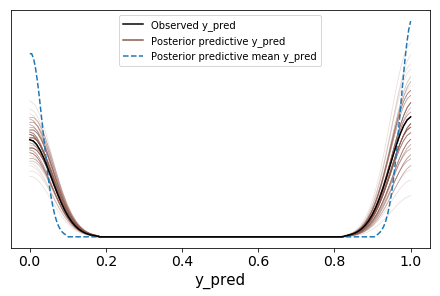

In [14]:
def plot_posterior(trace, model):
    ypred_samples = pm.sample_posterior_predictive(trace, 100, model)
    ypred_ppc = az.from_pymc3(trace=trace, posterior_predictive=ypred_samples)
    az.plot_ppc(ypred_ppc)
    plt.legend(loc="best")
    _ = plt.show()

plot_posterior(trace_q7a, model_q7a)

### Gaussian Process prior on space_flu (linear)

In [15]:
with pm.Model() as model_q7b:
    ls = pm.HalfNormal("ls", np.std(x))
    cov = pm.gp.cov.ExpQuad(1, ls=ls) + pm.gp.cov.WhiteNoise(1e-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=x.reshape(-1, 1))
    theta = pm.Deterministic("theta", pm.math.sigmoid(f))
    y_pred = pm.Bernoulli("y_pred", p=theta, observed=y)
    trace_q7b = pm.sample(1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, ls]
100%|██████████| 1500/1500 [00:17<00:00, 85.43it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


100%|██████████| 100/100 [00:00<00:00, 1285.96it/s]


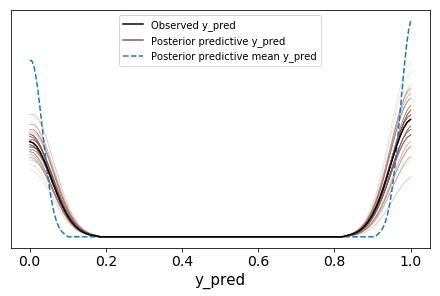

In [16]:
plot_posterior(trace_q7b, model_q7b)

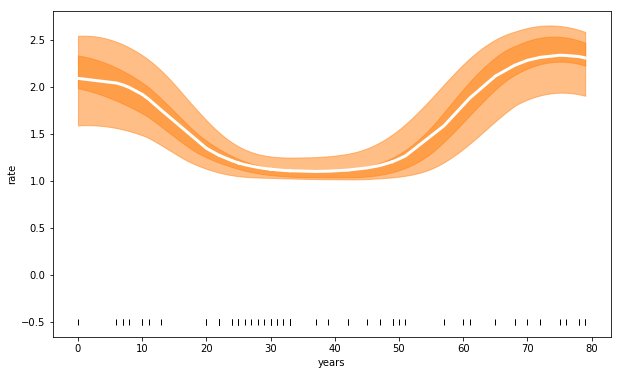

In [17]:
_, ax = plt.subplots(figsize=(10, 6))

theta_trace = np.exp(trace_q7b["theta"])
theta_median = np.median(theta_trace, axis=0)

# sort the x and theta values otherwise plot is messy
x_theta_pairs = sorted(zip(x, theta_median), key=operator.itemgetter(0))
x_ = [x_theta[0] for x_theta in x_theta_pairs]
theta_ = [x_theta[1] for x_theta in x_theta_pairs]
ax.plot(x_, theta_, 'w', lw=3)

az.plot_hpd(x, theta_trace)
az.plot_hpd(x, theta_trace, credible_interval=0.5, plot_kwargs={'alpha': 0})
ax.plot(x, np.zeros_like(x)-0.5, 'k|')

ax.set_xlabel('years')
ax.set_ylabel('rate')
_ = plt.show()

## Question 8

Change the logistic regression model in order to fit the data. Tip, use an order two polynomial.

<p>
    <font color="blue">
        <p>We solve this as before with a simple logistic regression model that is linear and quadratic on space_flu, as well as a model that uses a Gaussian process prior on the linear and quadratic of space_flu to determine the theta parameter for the Bernoulli likelihood.</p>
    </font>
</p>

### Simple Logistic Regression (linear + quadratic on space_flu)

In [18]:
with pm.Model() as model_q8a:
    alpha = pm.Normal("alpha", mu=0, sd=10)
    beta = pm.Normal("beta", mu=0, sd=10, shape=2)
    
    mu = alpha + (beta[0] * x) + (beta[1] * x**2)
    theta = pm.Deterministic("theta", pm.math.sigmoid(mu))
    
    y_pred = pm.Bernoulli("y_pred", p=theta, observed=y)

    trace_q8a = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:12<00:00, 655.15draws/s] 
The acceptance probability does not match the target. It is 0.6392269271018111, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


100%|██████████| 100/100 [00:00<00:00, 1985.66it/s]


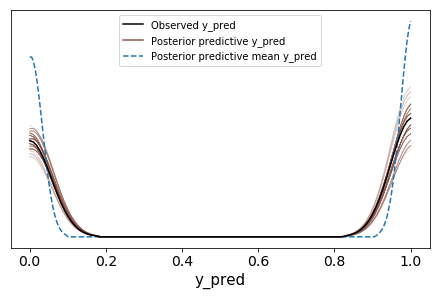

In [19]:
plot_posterior(trace_q8a, model_q8a)

In [20]:
az.summary(trace_q8a, var_names=["alpha", "beta"])

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
alpha,6.96,2.14,0.03,3.14,10.96,703.0,1.0
beta[0],-0.60,0.14,0.00,-0.87,-0.34,630.0,1.0
beta[1],0.01,0.00,0.00,0.00,0.01,648.0,1.0


### Gaussian Process Prior on space_flu (linear + quadratic)

In [21]:
X = np.stack((x, np.power(x, 2)), axis=1)
X.shape

(60, 2)

In [22]:
with pm.Model() as model_q8b:
    ls = pm.HalfNormal("ls", np.std(x))
    cov = pm.gp.cov.ExpQuad(1, ls=ls) + pm.gp.cov.WhiteNoise(1e-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X)
    theta = pm.Deterministic("theta", pm.math.sigmoid(f))
    y_pred = pm.Bernoulli("y_pred", p=theta, observed=y)
    trace_q8b = pm.sample(1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, ls]
100%|██████████| 1500/1500 [00:17<00:00, 87.81it/s] 
Only one chain was sampled, this makes it impossible to run some convergence checks


100%|██████████| 100/100 [00:00<00:00, 1414.03it/s]


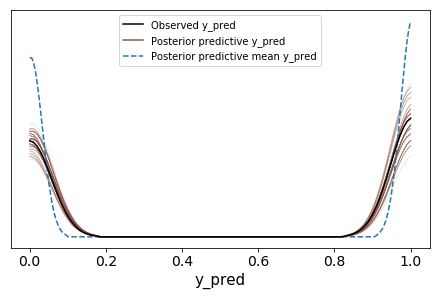

In [23]:
plot_posterior(trace_q8a, model_q8a)

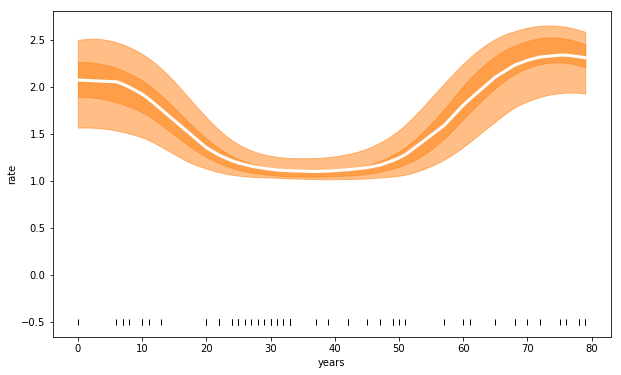

In [24]:
_, ax = plt.subplots(figsize=(10, 6))

theta_trace = np.exp(trace_q8b["theta"])
theta_median = np.median(theta_trace, axis=0)

# sort the x and theta values otherwise plot is messy
x_theta_pairs = sorted(zip(x, theta_median), key=operator.itemgetter(0))
x_ = [x_theta[0] for x_theta in x_theta_pairs]
theta_ = [x_theta[1] for x_theta in x_theta_pairs]
ax.plot(x_, theta_, 'w', lw=3)

az.plot_hpd(x, theta_trace)
az.plot_hpd(x, theta_trace, credible_interval=0.5, plot_kwargs={'alpha': 0})
ax.plot(x, np.zeros_like(x)-0.5, 'k|')

ax.set_xlabel('years')
ax.set_ylabel('rate')
_ = plt.show()

## Question 9

Compare the model for the coal mining disaster with the one from the PyMC3 documentation (https://docs.pymc.io/notebooks/getting_started.html#Case-study-2:-Coal-mining-disasters). Describe the differences between both models in terms of model-specification and results.

<p>
    <font color="blue">
        <ul>
            <li>The example on the PyMC3 documentation treats the distribution as two separate distribution and the objective is to find the switch point.</li>
            <li>The example in the book attempts to fit the data using logistic regression using <a href="https://docs.pymc.io/notebooks/GP-Latent.html">Latent Gaussian Priors</a> and fits a curve to the data where the switch point is predicted as a smooth decrease over multiple years.</li>
        </ul>
    </font>
</p>